Uczenie KNN

Rozpoznawanie 3 obiektów
- konik -> klasa 0
- ryba -> klasa 1
- butelka -> klasa 2

In [ ]:
klasa = {
    'konik': 0,
    'ryba': 1,
    'butelka': 2
}

In [ ]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2
import pandas
import pickle

from skimage.measure import label,regionprops

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn import tree

# zmiana sposobu wyświetlania danych typu float
pd.options.display.float_format = "{:.2f}".format 

In [ ]:
#FUNKCJE POMOCNICZE


def pob(im, tytul = "", osie = False, openCV = True, cmap = 'gray'):
    # pokaz obraz 
    # tytul - teskt wystwietlany nad obrazem
    # osie - czy osie są widoczne
    # openCV - czy obraz jest w standardzie openCV (tj BGR zamiast RGB)
    if not(osie):
        plt.axis("off") 
    if im.ndim == 2:
        plt.imshow(im,cmap)
    else:
        if openCV:
            plt.imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB));
        else:
            plt.imshow(im)        
    plt.title(tytul)

def plo(listaobr, ile_k = 1, listatyt = [], wart_dpi = 100, osie = False, openCV = True, colmap = 'gray'):
    # pokazuje liste obrazow kolorowych lub s skali szarosci
    # listaobr - lista obrazów
    # ile_k - liczba kolumn w jakich wyświetlamy obrazy
    # listatyt - lista tytułów obrazów
    # wart_dpi - wielkosc obrazu
    # osie, openCV - jak w funckji 'pob'
    rozm_obr = 5
    ile = len(listaobr)
    if len(listatyt) == 0:
        listatyt = [' ']*ile
    ile_w = np.ceil(ile / ile_k).astype(int)
    figsize_k = rozm_obr*ile_k
    figsize_w = rozm_obr*ile_w
    plt.figure(figsize=(figsize_k,figsize_w), dpi = wart_dpi)
    for i in range(0,ile):
        if isinstance(listaobr[i],np.ndarray):
            plt.subplot(ile_w,ile_k,i+1)
            pob(listaobr[i], listatyt[i], osie, openCV, colmap)
    plt.show()

"powierzchnia","powierzchnia bez dziur","liczba Eulera","wypełnienie","promień koła","wypełnienie bez dziur","typ obiektu"

Określenie wszystkich wyszukiwanych cech

In [ ]:
ile_obiektow = 3
lista_cech = ['EulerNumber','Area','BoundingBoxArea','FilledArea','Extent','EquivDiameter','Solidity', 'eccentricity', 'Area_FilledArea', 'major2minor', 'major_axis_length', 'minor_axis_length', 'bbarea_area']
ile_cech = len(lista_cech)
tabela_cech = np.zeros((ile_obiektow,ile_cech+1+7))

Stworzenie dataframa dla ułatwienia pracy na danych

In [ ]:
cechy = pd.DataFrame(columns = lista_cech + ["Class", "Hu1_log", "Hu2_log", "Hu3_log", "Hu4_log", "Hu5_log", "Hu6_log", "Hu7_log"])
cechy.head()

,EulerNumber,Area,BoundingBoxArea,FilledArea,Extent,EquivDiameter,Solidity,eccentricity,Area_FilledArea,major2minor,...,minor_axis_length,bbarea_area,Class,Hu1_log,Hu2_log,Hu3_log,Hu4_log,Hu5_log,Hu6_log,Hu7_log


Ekstrakcja cech dokładnie taka sama jak w pliku main.py do detekcji obiektów + określenie klasy obiektu

In [ ]:
def ekstrakcja_cech(o, klasa, cechy_df):
    # ekstrakcja cech
    # binaryzacja obrazu


    hsv = cv2.cvtColor(o, cv2.COLOR_BGR2HSV)
    hsv = cv2.GaussianBlur(hsv, (3,3), 0) 


    #maska od czerownego po zielony
    lower_red = np.array([0,0,100])
    upper_red = np.array([90,255,255])
    mask0 = cv2.inRange(hsv, lower_red, upper_red)

    lower_red = np.array([160,0,110])
    upper_red = np.array([180,255,255])
    mask1 = cv2.inRange(hsv, lower_red, upper_red)

    lower_white = np.array([0,0,225])
    upper_white = np.array([180,255,255])
    mask2 = cv2.inRange(hsv, lower_white, upper_white)

    lower_dark_greem = np.array([50,170,70])
    upper_dark_green = np.array([70,255,120])
    mask3 = cv2.inRange(hsv, lower_dark_greem, upper_dark_green)



    #mask=mask1
    mask = mask0 + mask1 + mask2 + mask3
    

    #Nakładanie maski na zdjęcie
    output_hsv = o.copy()
    output_hsv[np.where(mask==0)] = 0


    gray = cv2.cvtColor(output_hsv, cv2.COLOR_BGR2GRAY)
    ret, b = cv2.threshold(gray,20,255,0)
    elstr = np.ones((9,9),np.uint8)
    close = cv2.morphologyEx(b,cv2.MORPH_CLOSE,elstr, iterations =3)
    kernel= np.ones((5,5),np.uint8)
    close = cv2.erode(close, kernel, iterations = 3) 

    # etykietowanie i ekstrakcja cech
    cechy_ = regionprops(label(close))

    listaob = []
    ile_obiektow = len(cechy_)
    for i in range(0,ile_obiektow):
      cechy_dict = {}
      yp,xp,yk,xk = cechy_[i]['BoundingBox']
      aktualny_obiekt = o[yp:yk,xp:xk,:]
      ret,binobj = cv2.threshold(aktualny_obiekt[:,:,1],0,255,cv2.THRESH_BINARY)

      if cechy_[i][lista_cech[1]] < 6000:
        continue

      cechy_dict['Class'] = klasa

      cechy_dict[lista_cech[0]] = cechy_[i][lista_cech[0]]
      cechy_dict[lista_cech[1]] = cechy_[i][lista_cech[1]]
      cechy_dict[lista_cech[2]] = cechy_[i][lista_cech[2]]
      cechy_dict[lista_cech[3]] = cechy_[i][lista_cech[3]]
      cechy_dict[lista_cech[4]] = cechy_[i][lista_cech[4]]
      cechy_dict[lista_cech[5]] = cechy_[i][lista_cech[5]]
      cechy_dict[lista_cech[6]] = cechy_[i][lista_cech[6]]
      cechy_dict[lista_cech[7]] = cechy_[i][lista_cech[7]]
      cechy_dict[lista_cech[8]] = cechy_[i][lista_cech[1]]/cechy_[i][lista_cech[3]]
      cechy_dict[lista_cech[9]] = cechy_[i][lista_cech[10]]/cechy_[i][lista_cech[11]]
      cechy_dict[lista_cech[10]] = cechy_[i][lista_cech[10]]
      cechy_dict[lista_cech[11]] = cechy_[i][lista_cech[11]]
      cechy_dict[lista_cech[12]] = cechy_[i][lista_cech[2]]/cechy_[i][lista_cech[1]]

      cechy_dict['class'] = klasa

      listaob.append(binobj) #aktualny_obiekt)
      # rejestrujemy wybrane cechy wyznaczone przez regionprops
      # dodajemy momenty Hu   
      hu = cv2.HuMoments(cv2.moments(binobj))
      hulog = (1 - 2*(hu>0).astype('int'))* np.nan_to_num(np.log10(np.abs(hu)),copy=True,neginf=-99,posinf=99)
      hulog_flat = hulog.flatten()
      
      cechy_dict["Hu1_log"] = hulog_flat[0]
      cechy_dict["Hu2_log"] = hulog_flat[1]
      cechy_dict["Hu3_log"] = hulog_flat[2]
      cechy_dict["Hu4_log"] = hulog_flat[3]
      cechy_dict["Hu5_log"] = hulog_flat[4]
      cechy_dict["Hu6_log"] = hulog_flat[5]
      cechy_dict["Hu7_log"] = hulog_flat[6]

      cechy_dict["ktory_obiekt"] = i

      print(cechy_dict)

      cechy_df.loc[len(cechy_df)] = cechy_dict

    tabela_cech[:,0] = (tabela_cech[:,0] == 1) # korekta liczby Eulera
    return listaob, tabela_cech

Poniżej powtórzony kod z wyżej tylko w formie testów - z wyświetlaniem obrazów i wartości niektórych cech

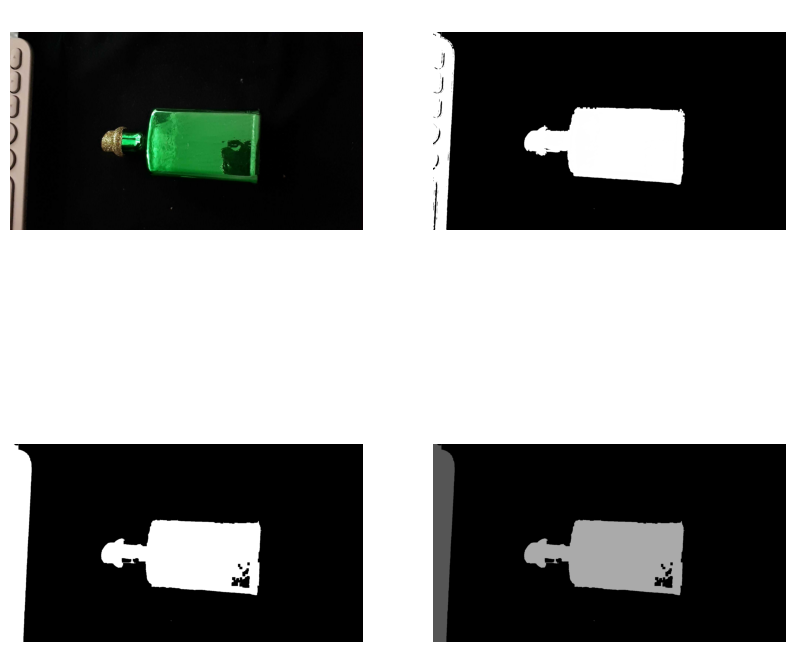

1080

In [ ]:
# wczytanie obrazu
o = cv2.imread("butelka000.jpg")
hsv = cv2.cvtColor(o, cv2.COLOR_BGR2HSV)
hsv = cv2.GaussianBlur(hsv, (9,9), 0) 


#maska od czerownego po zielony
lower_red2green = np.array([0,50,55])
upper_red2green = np.array([90,255,255])
mask0 = cv2.inRange(hsv, lower_red2green, upper_red2green)

lower_red = np.array([160,50,55])
upper_red = np.array([180,255,255])
mask1 = cv2.inRange(hsv, lower_red, upper_red)

lower_white = np.array([0,0,155])
upper_white = np.array([180,255,255])
mask2 = cv2.inRange(hsv, lower_white, upper_white)

lower_dark_greem = np.array([50,170,13])
upper_dark_green = np.array([70,255,120])
mask3 = cv2.inRange(hsv, lower_dark_greem, upper_dark_green)
kernel= np.ones((3,3),np.uint8)
mask3 = cv2.dilate(mask3, kernel, iterations = 3) 



#mask=mask3
mask = mask0 + mask1 + mask2 + mask3

#Nakładanie maski na zdjęcie
output_hsv = o.copy()
output_hsv[np.where(mask==0)] = 0


gray = cv2.cvtColor(output_hsv, cv2.COLOR_BGR2GRAY)
ret, b = cv2.threshold(gray,20,255,0)
elstr = np.ones((5,5),np.uint8)
close = cv2.morphologyEx(b,cv2.MORPH_CLOSE,elstr, iterations =3)
#kernel= np.ones((5,5),np.uint8)
#close = cv2.erode(close, kernel, iterations = 3) 


etykiety = label(close)
plo([o,mask, close, etykiety],2)
# wyznaczanie cech
cechy_ = regionprops(etykiety)
len(etykiety)
plo([cechy_[1]["image"]],1)


Wczytywanie zdjęć wraz z klasą

In [ ]:
o = cv2.imread("ryba27.jpg")
ekstrakcja_cech(o, klasa['ryba'], cechy)
cechy.head(10)

{'Class': 1, 'EulerNumber': 1, 'Area': 169233, 'BoundingBoxArea': 595428, 'FilledArea': 169233, 'Extent': 0.28422076220802517, 'EquivDiameter': 464.19192999681263, 'Solidity': 0.843142334729993, 'eccentricity': 0.9790873775566153, 'Area_FilledArea': 1.0, 'major2minor': 4.915449822781211, 'major_axis_length': 1056.824650161184, 'minor_axis_length': 215.00059776080107, 'bbarea_area': 3.518391803017142, 'class': 1, 'Hu1_log': 3.1782885727386287, 'Hu2_log': 7.893295242485939, 'Hu3_log': -99.0, 'Hu4_log': -99.0, 'Hu5_log': -99.0, 'Hu6_log': -99.0, 'Hu7_log': -99.0, 'ktory_obiekt': 0}


<ipython-input-166-ecb1db8c7f15>:86: RuntimeWarning: divide by zero encountered in log10
  hulog = (1 - 2*(hu>0).astype('int'))* np.nan_to_num(np.log10(np.abs(hu)),copy=True,neginf=-99,posinf=99)


,EulerNumber,Area,BoundingBoxArea,FilledArea,Extent,EquivDiameter,Solidity,eccentricity,Area_FilledArea,major2minor,...,minor_axis_length,bbarea_area,Class,Hu1_log,Hu2_log,Hu3_log,Hu4_log,Hu5_log,Hu6_log,Hu7_log
0,1,287617,394784,287617,0.73,605.15,0.89,0.89,1.00,2.19,...,427.99,1.37,2,3.05,6.44,40.06,39.73,79.72,42.98,-79.87
1,1,241700,519270,241700,0.47,554.74,0.84,0.91,1.00,2.40,...,380.74,2.15,2,3.14,6.99,16.48,16.28,32.92,19.88,-32.75
2,1,204593,299130,204593,0.68,510.39,0.89,0.90,1.00,2.33,...,350.18,1.46,2,3.04,6.38,15.72,15.91,31.74,19.10,32.37
3,1,189143,400820,189143,0.47,490.74,0.86,0.91,1.00,2.39,...,335.50,2.12,2,3.13,6.91,16.27,16.88,33.58,20.44,-33.63
4,1,214166,416592,214166,0.51,522.19,0.89,0.87,1.00,2.01,...,384.05,1.95,2,3.15,7.12,16.14,15.61,31.64,19.32,31.64
5,0,140990,322184,203672,0.44,423.69,0.60,0.88,0.69,2.13,...,378.17,2.29,2,3.07,6.55,16.45,17.25,34.23,21.09,34.25
6,1,203896,444962,203896,0.46,509.52,0.84,0.91,1.00,2.39,...,350.06,2.18,2,3.13,6.92,15.04,14.83,29.84,18.44,-30.05
7,1,178101,246008,178101,0.72,476.20,0.87,0.89,1.00,2.23,...,334.28,1.38,2,3.04,6.39,17.53,17.22,34.59,20.41,35.74
8,1,178077,260288,178077,0.68,476.17,0.86,0.90,1.00,2.34,...,329.93,1.46,2,3.04,6.40,15.26,15.12,30.32,18.32,31.27
9,0,181403,522004,207253,0.35,480.59,0.76,0.88,0.88,2.12,...,371.97,2.88,2,3.18,11.08,15.22,16.39,-32.20,-22.46,-33.34


Wybranie kilku cech na podstawie dataframe powyżej

In [ ]:
X = cechy[['EulerNumber','Solidity','Extent', 'eccentricity', 'Area_FilledArea', 'major2minor', 'bbarea_area']]
Y = cechy['Class']
y = Y.tolist()

Nauczenie modelu na podstawie wybranych cech

In [ ]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X, y)

KNeighborsClassifier()

Zapisanie modelu

In [ ]:
save_model(model, filename = 'finalized_model_14_14.sav')